<a href="https://colab.research.google.com/github/braxtonowens/OneraDataset/blob/master/ChangeDetection_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change Detection using the Unet

We first clone into my GitHub with the two datasets needed to train the model. 

In [1]:
!git clone https://github.com/braxtonowens/OneraDataset.git

Cloning into 'OneraDataset'...
remote: Enumerating objects: 1945, done.
remote: Total 1945 (delta 0), reused 0 (delta 0), pack-reused 1945
Receiving objects: 100% (1945/1945), 905.99 MiB | 18.85 MiB/s, done.
Resolving deltas: 100% (201/201), done.
Checking out files: 100% (1857/1857), done.


Import all libraries 

In [2]:
from osgeo import gdal
import numpy as np
import os
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

## Processing the Data

In [3]:
# Choose from bands (B01, B02, B02, B04, B05, B06, B07, B08, B09, B10, B11, B12, B8A)
channel = 'B04'
# path to Onera Dataset
mainDir = 'OneraDataset/OneraData'
images = '/images'
labels = '/labels'
IMAGE_SIZE = 112


def create_stacked_chips(channel, mainDir, images, labels, IMAGE_SIZE):
  mainPath = mainDir
  imgPath = mainDir + images
  lblPath = mainDir + labels
  img_list = np.zeros((650,112,112,2))
  lbl_list = np.zeros((650,112,112,1))
  city_ls = os.listdir(lblPath)
  city_ls.remove('README.txt')
  if not('mini_images' in os.listdir(mainPath)):
    os.mkdir(mainPath +'/mini_images')
    os.mkdir(mainPath +'/mini_labels')
  k = 0
  for city in city_ls:
    img_file1 = imgPath + '/'+ city + '/imgs_1_rect/' + channel + '.tif'
    ds = gdal.Open(img_file1, gdal.GA_ReadOnly)
    rb = ds.GetRasterBand(1)
    img1_array = rb.ReadAsArray()
    img_file2 = imgPath + '/' + city + '/imgs_2_rect/' + channel + '.tif'
    ds = gdal.Open(img_file2, gdal.GA_ReadOnly)
    rb = ds.GetRasterBand(1)
    img2_array = rb.ReadAsArray()
    lbl_file = lblPath + '/' + city + '/cm/' + city + '-cm' '.tif'
    ds = gdal.Open(lbl_file, gdal.GA_ReadOnly)
    rb = ds.GetRasterBand(1)
    lbl_array = rb.ReadAsArray()
    y = 0
    for i in range(img1_array.shape[1]//IMAGE_SIZE):
        x = 0
        for j in range(img1_array.shape[0]//IMAGE_SIZE):
            mini_img1 = img1_array[x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            mini_img2 = img2_array[x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            mini_lbl = lbl_array[x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            img_list[k] = tf.stack([mini_img1,mini_img2],axis=2)
            mini_lbl = np.expand_dims(mini_lbl,2)
            lbl_list[k] = (mini_lbl)
            x += IMAGE_SIZE
            k +=1
        y += IMAGE_SIZE

  cityL = ['Beirut','Brasilia','Cupertino','Dubai','Milano','Montepellier','Mumbai','Nantes','Paris','Pisa']
  cityCount = 0
  k = 0
  img_list1 = np.zeros((90,112,112,2))
  for root, dirs, files in os.walk('/content/OneraDataset/10Cities'):
    for dir in dirs:
      if dir.startswith(cityL[cityCount]):
        if dir.endswith("Clear"):
          ds = gdal.Open(root +'/'+ dir + '/' + channel + '.tif', gdal.GA_ReadOnly)
          rb = ds.GetRasterBand(1)
          img1_array = rb.ReadAsArray()
          ds = gdal.Open(root + '/' + dir[:-3] + 'oud/' + channel + '.tif', gdal.GA_ReadOnly)
          rb = ds.GetRasterBand(1)
          img2_array = rb.ReadAsArray()
          y = 0
          for i in range(img1_array.shape[1]//IMAGE_SIZE):
            x = 0
            for j in range(img1_array.shape[0]//IMAGE_SIZE):
                mini_img1 = img1_array[x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
                mini_img2 = img2_array[x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
                img_list1[k] = (tf.stack([mini_img1,mini_img2],axis=2))
                x += IMAGE_SIZE
                k +=1
            y += IMAGE_SIZE
  
    cityCount += 1
  img_list1 = np.array(img_list1)        
  img_list = np.concatenate((img_list,img_list1), axis = 0)

  lbl_list = lbl_list - 1

  tempLabel = np.zeros((90,112,112,1))
  
  lbl_list = np.concatenate((lbl_list,tempLabel), axis = 0)
  return img_list/4095, lbl_list 


X,y = create_stacked_chips(channel, mainDir, images, labels, IMAGE_SIZE)

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 48)

#delete to save ram space
del X, y

Augmenting the data

In [4]:
def randomRotation(X_train, y_train):
  aug_X_train = np.zeros((len(X_train) * 4,112,112,2))
  aug_y_train = np.zeros((len(y_train) * 4,112,112,1))
  j = 0
  # Augment data
  for i in range(len(X_train)):
    aug_X_train[j] = X_train[i]
    aug_y_train[j] = y_train[i]
    j+=1
    a = np.rot90(X_train[i],1)
    b = np.rot90(y_train[i],1)
    aug_X_train[j] = a
    aug_y_train[j] = b
    j+=1
    a = np.rot90(X_train[i],2)
    b = np.rot90(y_train[i],2)
    aug_X_train[j] = a
    aug_y_train[j] = b
    j+=1
    a = np.rot90(X_train[i],3)
    b = np.rot90(y_train[i],3)
    aug_X_train[j] = a
    aug_y_train[j] = b
    j+=1

  # Shuffle data
  seed = np.random.randint(0, 100000)  
  np.random.seed(seed)  
  np.random.shuffle(aug_X_train)  
  np.random.seed(seed)  
  np.random.shuffle(aug_y_train)     
  return aug_X_train,aug_y_train
    

X_train,y_train = randomRotation(X_train,y_train)

## Defining the Model

In [5]:
def unet(pretrained_weights = None,input_size = (112,112,2)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
 
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
   
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10) 
    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy' , metrics = ['accuracy'])
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

Model Summary

In [6]:
model = unet()
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 1216        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

## Training the Model

In [7]:
history = model.fit(X_train, y_train, batch_size=2, epochs=10, verbose=1, validation_split=0.2, shuffle=True)

Epoch 1/10
792/792 [==============================] - 106s 134ms/step - loss: 0.1877 - accuracy: 0.9701 - val_loss: 0.1045 - val_accuracy: 0.9718
Epoch 2/10
792/792 [==============================] - 106s 133ms/step - loss: 0.1199 - accuracy: 0.9719 - val_loss: 0.1015 - val_accuracy: 0.9723
Epoch 3/10
792/792 [==============================] - 106s 134ms/step - loss: 0.1040 - accuracy: 0.9727 - val_loss: 0.0935 - val_accuracy: 0.9739
Epoch 4/10
792/792 [==============================] - 106s 134ms/step - loss: 0.0984 - accuracy: 0.9733 - val_loss: 0.0856 - val_accuracy: 0.9748
Epoch 5/10
792/792 [==============================] - 106s 134ms/step - loss: 0.0931 - accuracy: 0.9740 - val_loss: 0.0855 - val_accuracy: 0.9747
Epoch 6/10
792/792 [==============================] - 106s 134ms/step - loss: 0.0884 - accuracy: 0.9743 - val_loss: 0.0785 - val_accuracy: 0.9748
Epoch 7/10
792/792 [==============================] - 106s 134ms/step - loss: 0.0879 - accuracy: 0.9742 - val_loss: 0.0862 -

## Testing the Model

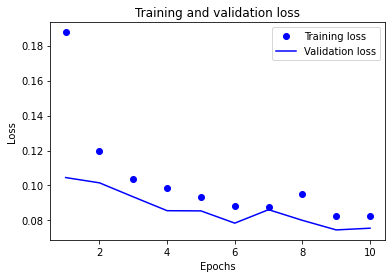

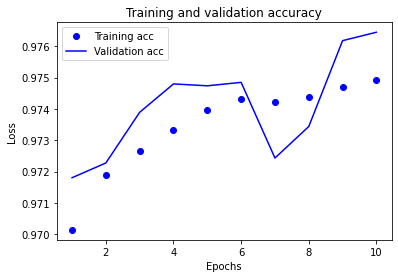

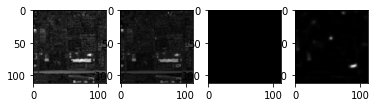

Dice similarity score is 0.0


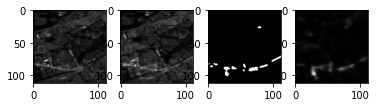

Dice similarity score is 0.1240384708343427


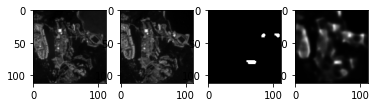

Dice similarity score is 0.10842834677484342


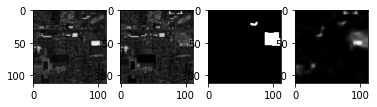

Dice similarity score is 0.40108350953812355


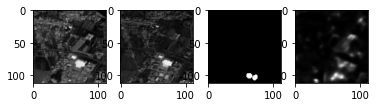

Dice similarity score is 0.10250609917237719


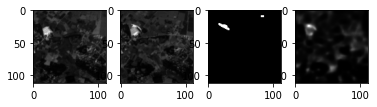

Dice similarity score is 0.10107281273810362


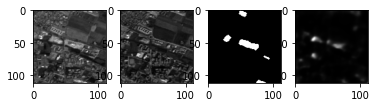

Dice similarity score is 0.11924975316632805


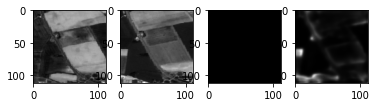

Dice similarity score is 0.0


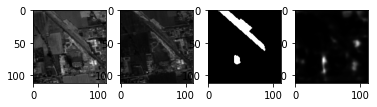

Dice similarity score is 0.036616934597924894


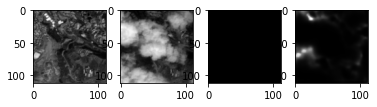

Dice similarity score is 0.0


In [8]:
results = model.predict(X_test)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

sumdice = 0
for i in range(10):

  img = results[i]
  img1 = y_test[i]
  img2 = X_test[i]
  fig, (ax1, ax2, ax3, ax4) =  plt.subplots(1,4)
  ax1.imshow(img2[:,:,0], cmap = 'gray')
  ax2.imshow(img2[:,:,1], cmap = 'gray')
  ax4.imshow(img[:,:,0], cmap = 'gray')
  ax3.imshow(img1[:,:,0], cmap = 'gray')
  plt.show()
  dice = np.sum(img[:,:,0][img1[:,:,0]==1])*2.0 / (np.sum(img[:,:,0]) + np.sum(img1[:,:,0]))
  print("Dice similarity score is {}".format(dice))

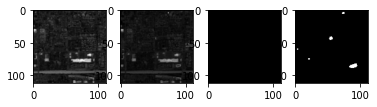

Dice similarity score is 0.0


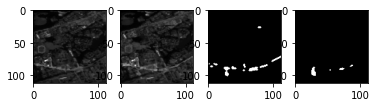

Dice similarity score is 0.4110854503464203


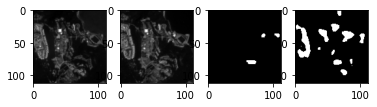

Dice similarity score is 0.15675675675675677


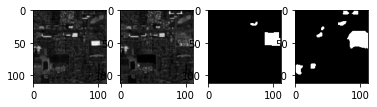

Dice similarity score is 0.6054054054054054


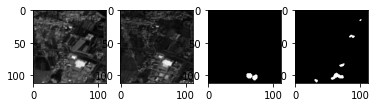

Dice similarity score is 0.5359477124183006


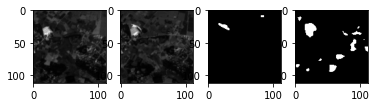

Dice similarity score is 0.18823529411764706


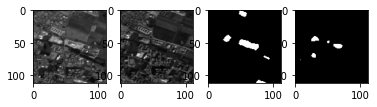

Dice similarity score is 0.4167832167832168


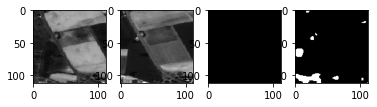

Dice similarity score is 0.0


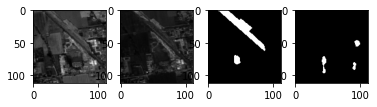

Dice similarity score is 0.11074380165289256


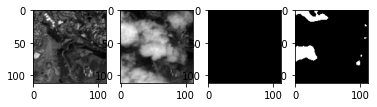

Dice similarity score is 0.0


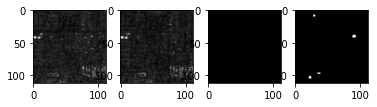

Dice similarity score is 0.0


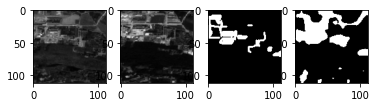

Dice similarity score is 0.4514400535833891


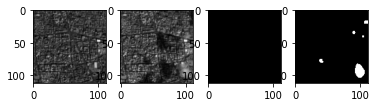

Dice similarity score is 0.0


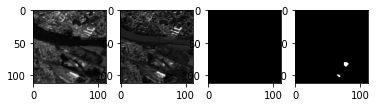

Dice similarity score is 0.0


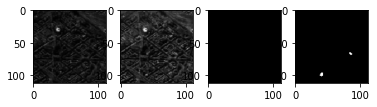

Dice similarity score is 0.0


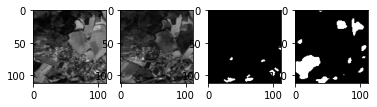

Dice similarity score is 0.10721868365180467


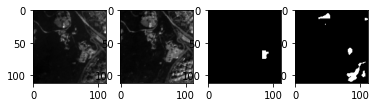

Dice similarity score is 0.09398496240601503


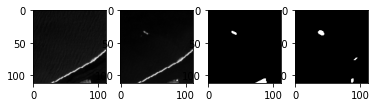

Dice similarity score is 0.5


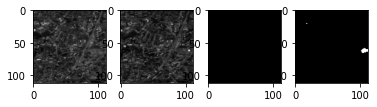

Dice similarity score is 0.0


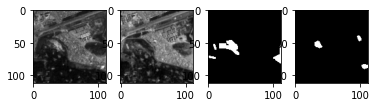

Dice similarity score is 0.23841059602649006


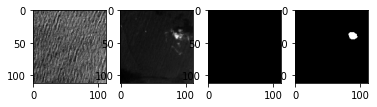

Dice similarity score is 0.0


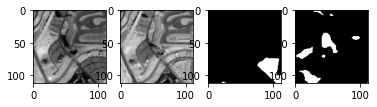

Dice similarity score is 0.010427528675703858


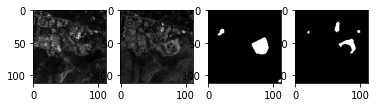

Dice similarity score is 0.5291479820627802


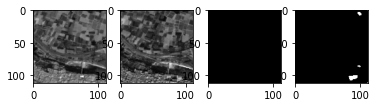

Dice similarity score is 0.0


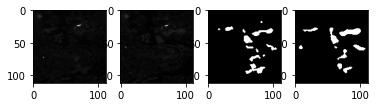

Dice similarity score is 0.6931316950220542


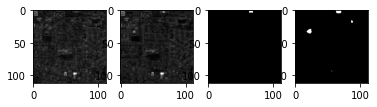

Dice similarity score is 0.34285714285714286


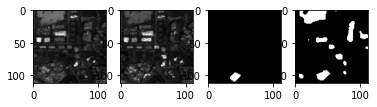

Dice similarity score is 0.15735735735735737


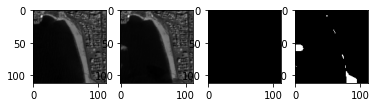

Dice similarity score is 0.0


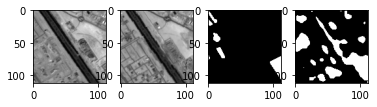

Dice similarity score is 0.2715249662618084


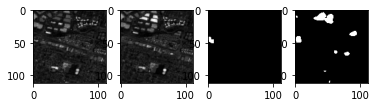

Dice similarity score is 0.17391304347826086


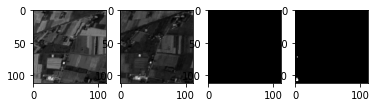

Dice similarity score is 0.0


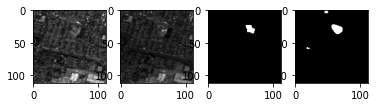

Dice similarity score is 0.7072463768115942


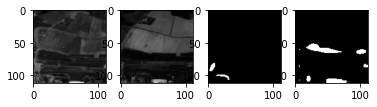

Dice similarity score is 0.018691588785046728


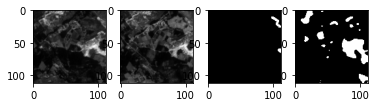

Dice similarity score is 0.010759115361625823


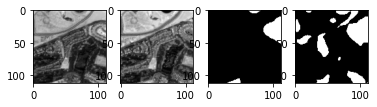

Dice similarity score is 0.49000571102227297


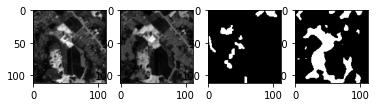

Dice similarity score is 0.3564356435643564


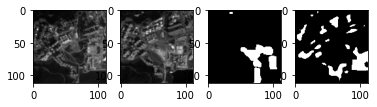

Dice similarity score is 0.25829307568438004


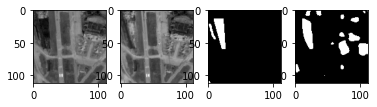

Dice similarity score is 0.42645074224021595


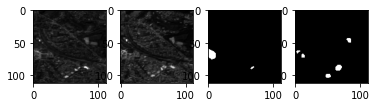

Dice similarity score is 0.2346368715083799


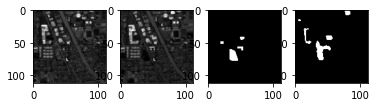

Dice similarity score is 0.5505050505050505


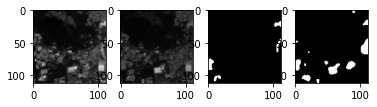

Dice similarity score is 0.4209621993127148


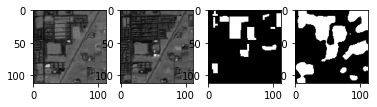

Dice similarity score is 0.5766352098926131


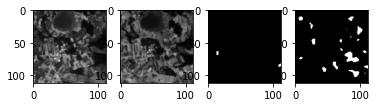

Dice similarity score is 0.02023121387283237


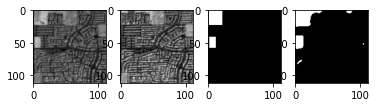

Dice similarity score is 0.7919951485748938


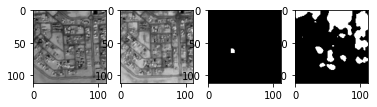

Dice similarity score is 0.02620967741935484


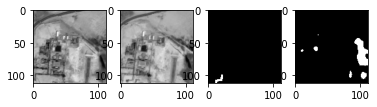

Dice similarity score is 0.0


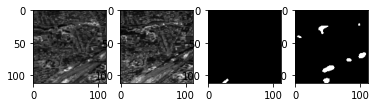

Dice similarity score is 0.0


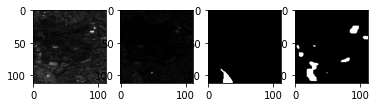

Dice similarity score is 0.2904040404040404


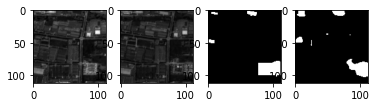

Dice similarity score is 0.7165532879818595


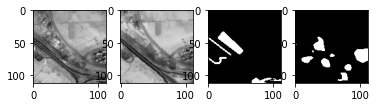

Dice similarity score is 0.26095329802599904


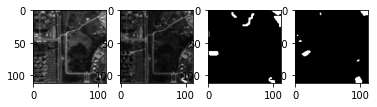

Dice similarity score is 0.40801001251564456


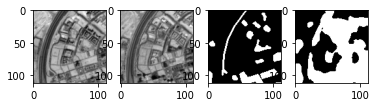

Dice similarity score is 0.4353511441776575


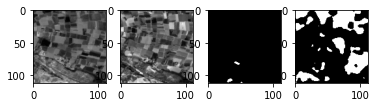

Dice similarity score is 0.02041912950026867


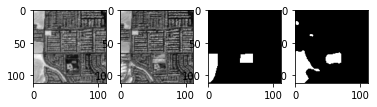

Dice similarity score is 0.7451879010082493


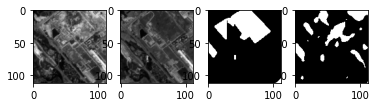

Dice similarity score is 0.49955985915492956


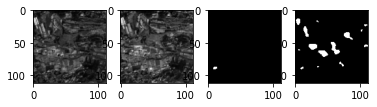

Dice similarity score is 0.040880503144654086


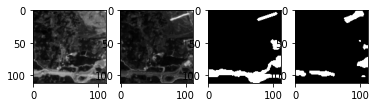

Dice similarity score is 0.5781487101669196


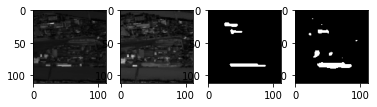

Dice similarity score is 0.6088669950738916


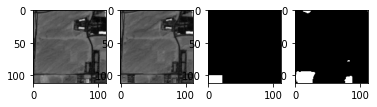

Dice similarity score is 0.5454545454545454


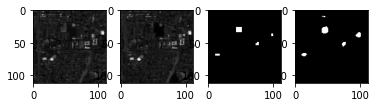

Dice similarity score is 0.6785714285714286


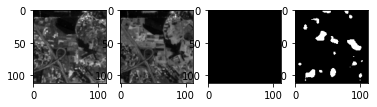

Dice similarity score is 0.0


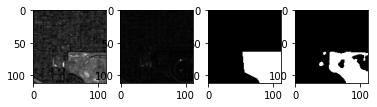

Dice similarity score is 0.8560739436619719


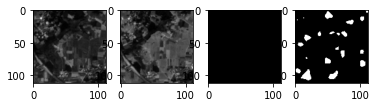

Dice similarity score is 0.0


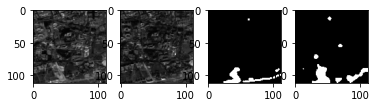

Dice similarity score is 0.6027007818052594


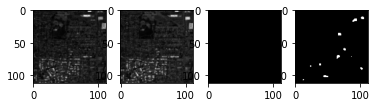

Dice similarity score is 0.0


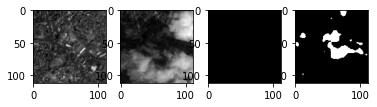

Dice similarity score is 0.0


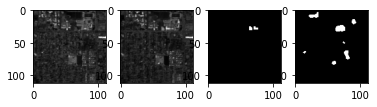

Dice similarity score is 0.2505800464037123


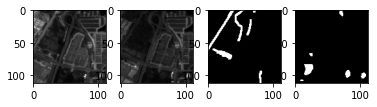

Dice similarity score is 0.12238325281803543


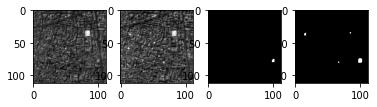

Dice similarity score is 0.47368421052631576


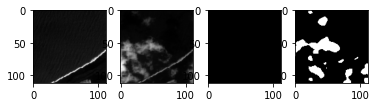

Dice similarity score is 0.0


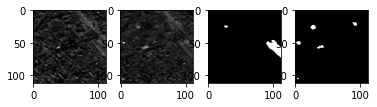

Dice similarity score is 0.06971677559912855


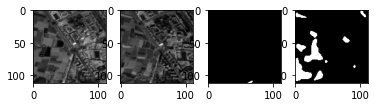

Dice similarity score is 0.0


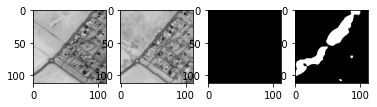

Dice similarity score is 0.0


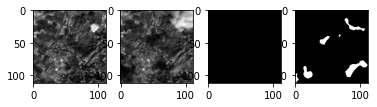

Dice similarity score is 0.0


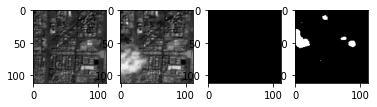

Dice similarity score is 0.0


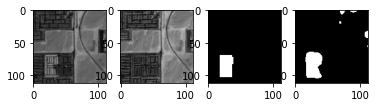

Dice similarity score is 0.7813238770685579


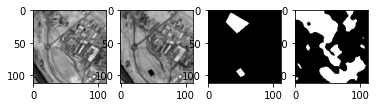

Dice similarity score is 0.26834052569635153


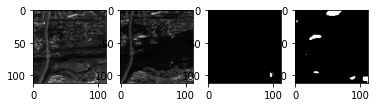

Dice similarity score is 0.0


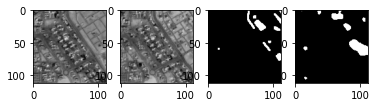

Dice similarity score is 0.3680456490727532


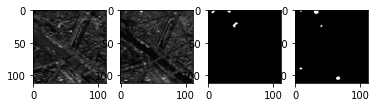

Dice similarity score is 0.423841059602649


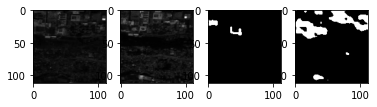

Dice similarity score is 0.17252695733708392


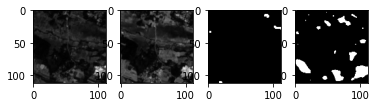

Dice similarity score is 0.0416367552045944


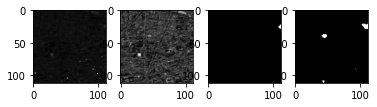

Dice similarity score is 0.29508196721311475


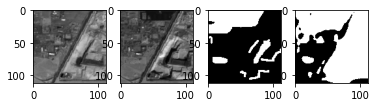

Dice similarity score is 0.5386115114012037


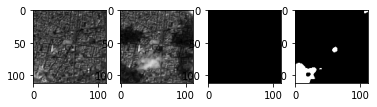

Dice similarity score is 0.0


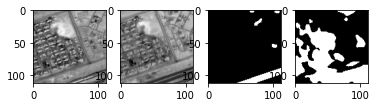

Dice similarity score is 0.20194892473118278


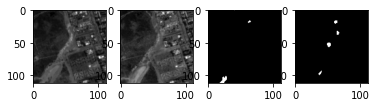

Dice similarity score is 0.12121212121212122


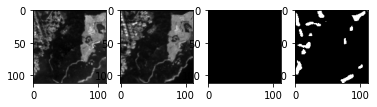

Dice similarity score is 0.0


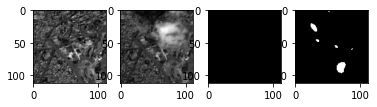

Dice similarity score is 0.0


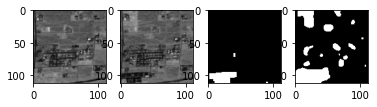

Dice similarity score is 0.395053246307111


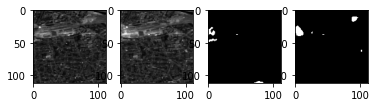

Dice similarity score is 0.42359249329758714


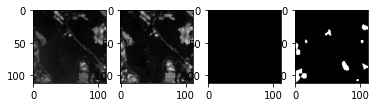

Dice similarity score is 0.0


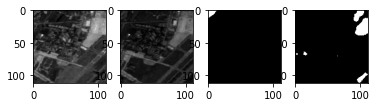

Dice similarity score is 0.0025157232704402514


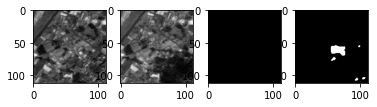

Dice similarity score is 0.0


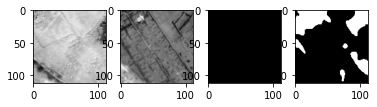

Dice similarity score is 0.0


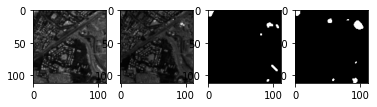

Dice similarity score is 0.48073394495412847


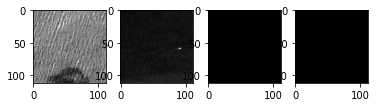

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


Dice similarity score is nan


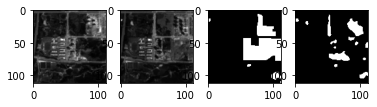

Dice similarity score is 0.42491657397107896


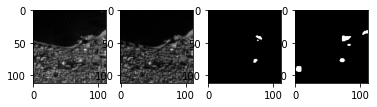

Dice similarity score is 0.40615384615384614


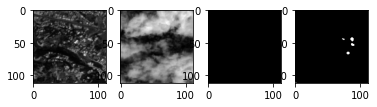

Dice similarity score is 0.0
Dice similarity score is 0.3394888052308302


In [9]:
tempArray = np.copy(results)
for element in np.nditer(tempArray, op_flags=['readwrite']):
  if element > .1:
    element[...] = 1
  else:
    element[...] = 0
y = []
numer = 0
denom = 0
for i in range(100):
  img = tempArray[i]
  img1 = y_test[i]
  img2 = X_test[i]
  fig, (ax1, ax2, ax3, ax4) =  plt.subplots(1,4)
  ax1.imshow(img2[:,:,0], cmap = 'gray')
  ax2.imshow(img2[:,:,1], cmap = 'gray')
  ax4.imshow(img[:,:,0], cmap = 'gray')
  ax3.imshow(img1[:,:,0], cmap = 'gray')
  plt.show()
  dice = np.sum(img[:,:,0][img1[:,:,0]==1])*2.0 / (np.sum(img[:,:,0]) + np.sum(img1[:,:,0]))
  numer += np.sum(img[:,:,0][img1[:,:,0]==1])
  denom += (np.sum(img[:,:,0]) + np.sum(img1[:,:,0]))
  dice1 = np.sum(img[:,:,0][img1[:,:,0]==1])*2.0 / (np.sum(img[:,:,0]) + np.sum(img1[:,:,0]))
  print("Dice similarity score is {}".format(dice1))
  dice = numer * 2/ denom

print("Dice similarity score is {}".format(dice))